In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Python >= 3.5 is required
import sys
assert sys.version_info >= (3,5)

# Scikit-Learn >= 0.20 is required
import sklearn 
assert sklearn.__version__ >= "0.20"

# common imports
import pandas as pd
import numpy as np 
import glob
import os 
from numpy import genfromtxt


# to plot pretty figures
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
DATASET_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
# path to csv files
path_to_train_csvs = os.path.join(DATASET_PATH, "train")
path_to_val_csvs = os.path.join(DATASET_PATH, "val")
path_to_test_csvs = os.path.join(DATASET_PATH, "test")

## Part 3. <font color=green>Predicting of a user's coordinates using feed forward neural networks</font>



### Task 1. Copy and paste your previous implementations of <font color=blue>build_feats</font>, <font color=blue>build_feats_targets</font>, and <font color=blue>euclidean_distance</font>



In [11]:
def build_feats(path_to_csvs):
    my_data = genfromtxt(f'{path_to_csvs}/1.csv', delimiter=',')
    
    my_data2 = genfromtxt(f'{path_to_csvs}/2.csv', delimiter=',')
    
    feats = np.concatenate((my_data, my_data2), axis=0)

    
    files = os.path.join(path_to_csvs, "*.csv")

    files = glob.glob(files)
    
    files.remove(f'{path_to_csvs}/1.csv')
    files.remove(f'{path_to_csvs}/2.csv')
    
    for file in files:
        my_data = genfromtxt(file, delimiter=',')
        feats = np.concatenate((feats, my_data), axis=0)
    
    return feats

def build_feats_targets(path_to_csvs):
    my_data = genfromtxt(f'{path_to_csvs}/1.csv', delimiter=',')
    
    my_data2 = genfromtxt(f'{path_to_csvs}/2.csv', delimiter=',')
    
    data_set = np.concatenate((my_data, my_data2), axis=0)
    
    files = os.path.join(path_to_csvs, "*.csv")

    files = glob.glob(files)
    
    files.remove(f'{path_to_csvs}/1.csv')
    files.remove(f'{path_to_csvs}/2.csv')
    
    for file in files:
        my_data = genfromtxt(file, delimiter=',')
        data_set = np.concatenate((data_set, my_data), axis=0)

    feats = data_set[:, :-3]
    targets = data_set[:, -3:]
    
    
    
    return feats, targets

def mean_error_dist(targets, preds):
    sum = 0
    for i in range(len(targets)):
        sum += np.linalg.norm(targets[i] - preds[i])
    dist = sum / len(targets)
    return dist


### <font color=red>NOTE !</font> 
Before we feed the data to a neural network, we first need to normalize it and substract the mean for a better convergence. 
   

In [12]:
feats_train, targets_train = build_feats_targets(path_to_train_csvs)
feats_train = (feats_train.astype('float32') + 100.0) / 100.0
mean = np.mean(feats_train)
feats_train_norm = (feats_train - mean)

# verify dimensions of the returned feature matrix and a target matrix
assert(feats_train.shape == (6049,220))
assert(targets_train.shape == (6049,3))

In [13]:
feats_val, targets_val = build_feats_targets(path_to_val_csvs)
feats_val = (feats_val.astype('float32') + 100.0) / 100.0
feats_val_norm = (feats_val - mean)

# verify dimensions of the returned feature matrix and a target matrix
assert(feats_val.shape == (1976,220))
assert(targets_val.shape == (1976,3))

In [14]:
feats_test = build_feats(path_to_test_csvs)
feats_test = (feats_test.astype('float32') + 100.0) / 100.0
feats_test_norm = (feats_test - mean)

# verify dimensions of the returned feature matrix
assert(feats_test.shape == (2601,220))

### Task 2. Using feed forward neural networks.
For this part, we provide you with a simple feed forward neural network (or a multi layer perceptron). The code is is given below.  You can tune the parameters, extend the network and even modify the model as you see fit in order to find the best model.

In [15]:
def lr_schedule(epoch):
    """Learning Rate Schedule
        # Arguments
            epoch (int): The number of epochs

        # Returns
            lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 50:
        lr = 1e-4
        
    print('Learning rate: ', lr)
    return lr

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [17]:
# network parameters
input_size = feats_train.shape[1]
epochs = 100
batch_size = 8
hidden_units = 128
dropout = 0.1

# model is a 3-layer MLP with ReLU and dropout after each layer
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               28288     
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               1

2022-10-27 15:49:35.316893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-27 15:49:35.316952: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 15:49:35.316999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nandi-5420): /proc/driver/nvidia/version does not exist
2022-10-27 15:49:35.317595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
optimizer = Adam(lr=lr_schedule(0))
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])

# train the network
H = model.fit(
    feats_train_norm, targets_train,
    validation_data=(feats_val_norm, targets_val), 
    batch_size=batch_size, 
    epochs=epochs,
    shuffle=True)

Learning rate:  0.001
Epoch 1/100


/home/nandi/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


757/757 [==============================] - 2s 2ms/step - loss: 43.4397 - mae: 3.9943 - val_loss: 8.5662 - val_mae: 1.9768
Epoch 2/100
757/757 [==============================] - 1s 2ms/step - loss: 12.5474 - mae: 2.4899 - val_loss: 6.4045 - val_mae: 1.6825
Epoch 3/100
757/757 [==============================] - 1s 2ms/step - loss: 10.5091 - mae: 2.2550 - val_loss: 5.6127 - val_mae: 1.6042
Epoch 4/100
757/757 [==============================] - 1s 1ms/step - loss: 9.7139 - mae: 2.1679 - val_loss: 5.2933 - val_mae: 1.5635
Epoch 5/100
757/757 [==============================] - 1s 1ms/step - loss: 8.9166 - mae: 2.0686 - val_loss: 5.5617 - val_mae: 1.4922
Epoch 6/100
757/757 [==============================] - 1s 1ms/step - loss: 8.2599 - mae: 1.9947 - val_loss: 7.3529 - val_mae: 1.7660
Epoch 7/100
757/757 [==============================] - 1s 2ms/step - loss: 7.6958 - mae: 1.9461 - val_loss: 4.3380 - val_mae: 1.3852
Epoch 8/100
757/757 [==============================] - 1s 2ms/step - loss: 7.3

Take advantage of the code below to visualize the progression of your training

Saving figure mse_loss


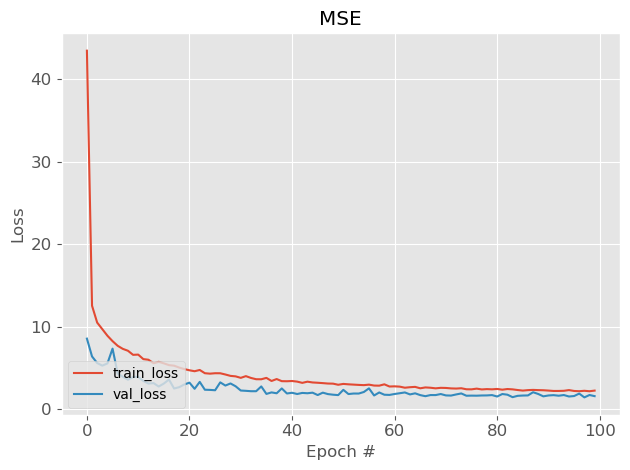

In [19]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("MSE")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
save_fig("mse_loss")

Saving figure mae_loss


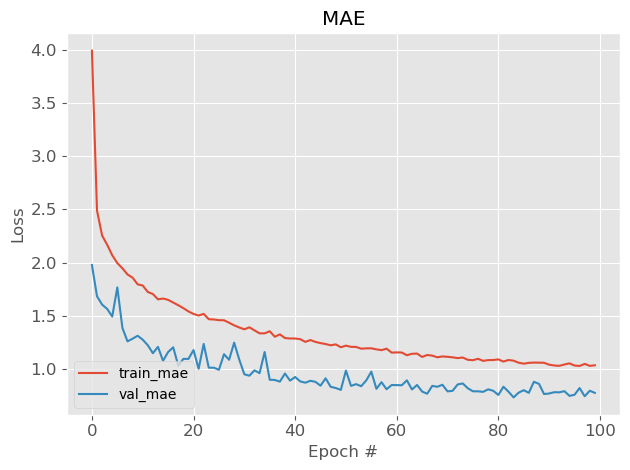

In [20]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["mae"], label="train_mae")
plt.plot(np.arange(0, epochs), H.history["val_mae"], label="val_mae")
plt.title("MAE")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
save_fig("mae_loss")

Feel free to experiment with the network and let us know what result you got

In [21]:
preds = model.predict(feats_val_norm, batch_size=batch_size)
mean_error_dist(targets_val, preds)

247/247 [==============================] - 0s 646us/step


1.7975094534536684

### Feel free to experiment with the network or come up with a different DL approach. 
### The best mean error distance we got so far is 1.44.  Email us (<font color=blue>issai@nu.edu.kz</font>) the predictions of your best estimator on the test features AND your solutions to see how well you did !
<font color=red> Please don't forget that the target values of test set are stacked in the order of csv files. If your test features do not follow this order, your result will be ruined.</font>

In [22]:
preds = model.predict(feats_test_norm, batch_size=batch_size)

name = "John" # change to your first name
surname = "Snow" # change to your lastname

# email your csv file to issai@nu.edu.kz
pd.DataFrame(preds).to_csv("{}_{}.csv".format(name, surname), header=None, index=None)

326/326 [==============================] - 0s 658us/step
